# Classifiers, Object Recognition

## 0. Preparation

In [583]:
from google.colab import drive
import time
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cv2
import sklearn
from sklearn import svm, metrics, ensemble

In [584]:
print("pickle: {}".format(pickle.format_version))
print("numpy: {}".format(np.__version__))
print("matplotlib: {}".format(matplotlib.__version__))
print("cv2: {}".format(cv2.__version__))
print("sklearn: {}".format(sklearn.__version__))

pickle: 4.0
numpy: 1.25.2
matplotlib: 3.7.1
cv2: 4.8.0
sklearn: 1.2.2


In [549]:
PATH = "/content/drive/MyDrive/McGill/ECSE415/Assignment3"
#drive.mount('/content/drive')

Make sure that the directory structure is as follows.



> .
>> ---Assignment 3.ipynb
>>
>> ---data
>>
>>> ---cifar_10
>>>
>>> ---Q2 part1
>>>
>>> ---Q2 part2







## 1. CIFAR10 Classification using SVM and Random Forest

In [550]:
# open byte encoded files and loat to a dictionary
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# REFERENCE: https://www.cs.toronto.edu/~kriz/cifar.html

In [551]:
# construct an image from dictionary
def batch2image(batch):
  red = np.reshape(batch[0:1024], (32,32))
  green = np.reshape(batch[1024:2048], (32,32))
  blue = np.reshape(batch[2048:3072], (32,32))
  img = np.stack((red, green, blue), axis=-1)
  img = cv2.resize(img, (64, 64))
  return img

In [552]:
# construct the image datasets from image batches
def construct_image_dataset():
  batch_names = ["data_batch_1", "data_batch_2", "data_batch_3", "data_batch_4", "data_batch_5", "test_batch"]
  dataset = dict() # structure of "dataset" is explained in the text box right below
  train_images = [] # containes 5 lists (batches) of 10000 images
  train_labels = [] # containes 5 lists (batches) of corresponding labels

  for batch_name in batch_names:
    file_path = PATH + f"/data/cifar_10/{ batch_name }"
    batch = unpickle(file_path)
    batch_images = [] # containes 10000 images from the same batch

    for image_line in batch[b'data']:
      img = batch2image(image_line)
      img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
      batch_images.append(img_gray)

    if batch_name == "test_batch":
      dataset["test_x"] = np.array(batch_images)
    else:
      train_images.append(batch_images)

    if batch_name == "test_batch":
      dataset["test_y"] = np.array(batch[b'labels'])
    else:
      train_labels.append(batch[b'labels'])

  label_names = unpickle(PATH + "/data/cifar_10/batches.meta")
  y_names = [byte_name.decode("utf-8") for byte_name in label_names[b'label_names']]
  dataset["y_names"] = np.array(y_names) # list of label names to corresponding indices
  dataset["train_x"] = np.array(train_images)
  dataset["train_y"] = np.array(train_labels)
  return dataset

**Structure of dataset**

| key name | array shape | details |
| --- | --- | --- |
| train_x | (5, 10000, 64, 64) | 5 batches of 10000 grayscale images of size 64x64 |
| train_y | (5, 10000) | 5 batches of 10000 integers (0-9) |
| test_x | (10000, 64, 64) | 10000 grayscale images of size 64x64 |
| test_y | (10000,) | 10000 integers (0-9)  |
| y_names | (10,) | label names |



In [553]:
def get_feature_vectors(images, win_size = (64, 64), block_size = (32, 32), block_stride = (8, 8), cell_size = (8, 8), nbins = 4):
  hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)
  feature_vectors = dict()
  train_vectors = [] # contains 5 lists (batches) of 10000 hog descriptors
  test_vectors = [] # contains 10000 hog descriptors

  # iteration for 5 training batches
  for batch_images in images["train_x"]:
    batch_vectors = []
    for img in batch_images:
      hog_descriptor = hog.compute(img)
      batch_vectors.append(hog_descriptor)
    train_vectors.append(batch_vectors)

  # for test batch
  for img in images["test_x"]:
    hog_descriptor = hog.compute(img)
    test_vectors.append(hog_descriptor)

  feature_vectors["train_x"] = np.array(train_vectors)
  feature_vectors["test_x"] = np.array(test_vectors)

  return feature_vectors

# https://medium.com/@dnemutlu/hog-feature-descriptor-263313c3b40d



---



In [554]:
dataset = construct_image_dataset()
feature_vectors = get_feature_vectors(dataset)

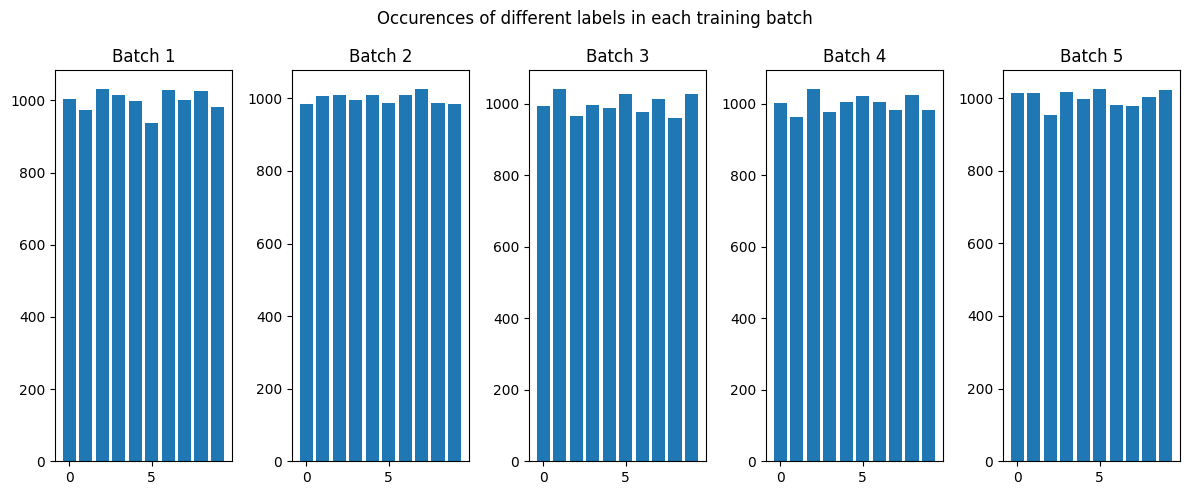

In [555]:
fig, ax = plt.subplots(ncols=5, figsize=(12, 5))
fig.suptitle("Occurences of different labels in each training batch")
for i in range(5):
  hist, bins = np.histogram(dataset["train_y"][i])
  ax[i].bar(range(10), hist)
  ax[i].set_title(f"Batch { i+1 }")
plt.tight_layout()

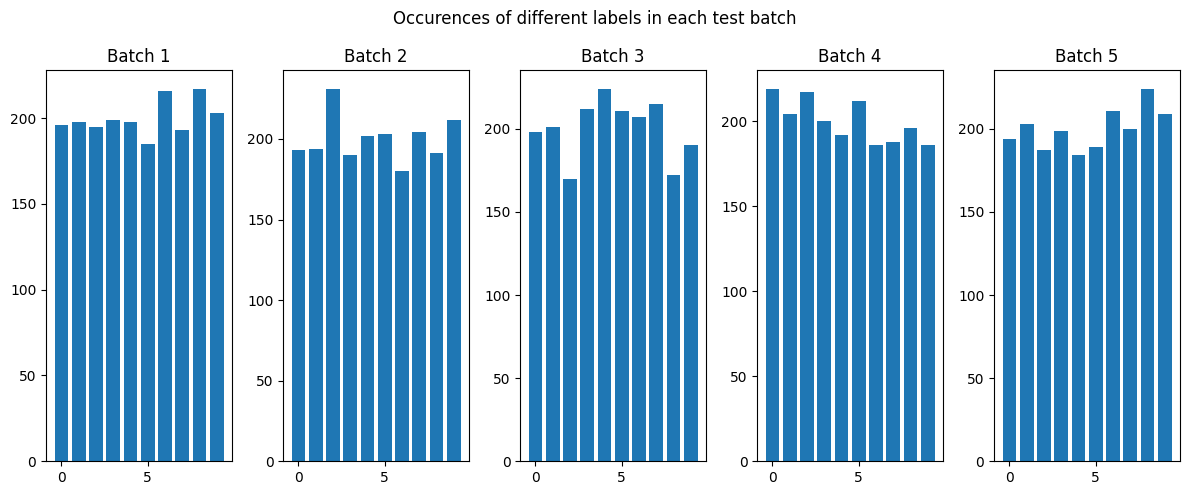

In [556]:
fig, ax = plt.subplots(ncols=5, figsize=(12, 5))
fig.suptitle("Occurences of different labels in each test batch")
for i in range(5):
  hist, bins = np.histogram(dataset["test_y"][2000*i:2000*(i+1)])
  ax[i].bar(range(10), hist)
  ax[i].set_title(f"Batch { i+1 }")
plt.tight_layout()

### SVC with default parameters

For less computation, I have chosen...

* data_batch_1 (10000 images) for training the non-linear SVC with default parameters.
* the first 2000 images of test_batch for testing the non-linear SVC with default parameters.

In [557]:
classifier = svm.SVC()
classifier.fit(feature_vectors["train_x"][0], dataset["train_y"][0])

# https://www.datacamp.com/tutorial/svm-classification-scikit-learn-python

SVC()

In [558]:
y_pred = classifier.predict(feature_vectors["test_x"][0:2000])
print("Accuracy:", metrics.accuracy_score(dataset["test_y"][0:2000], y_pred))

Accuracy: 0.563


### SVC fine-tuning

For less computation, I have chosen...
* the first 2000 images of data_batch_1 for fine-tuning the non-linear SVC.
* the first 500 images of test_batch for testing each model.

In [559]:
parameters = {'C': [1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001]}

for C in parameters['C']:
  for gamma in parameters['gamma']:
    classifier = svm.SVC(C=C, gamma=gamma)
    classifier.fit(feature_vectors["train_x"][0][0:2000], dataset["train_y"][0][0:2000])
    y_pred = classifier.predict(feature_vectors["test_x"][0:500])
    accuracy = metrics.accuracy_score(dataset["test_y"][0:500], y_pred)
    print(f"Accuracy: { accuracy } (C={ C }, gamma={ gamma })")

Accuracy: 0.108 (C=1, gamma=1)
Accuracy: 0.45 (C=1, gamma=0.1)
Accuracy: 0.364 (C=1, gamma=0.01)
Accuracy: 0.166 (C=1, gamma=0.001)
Accuracy: 0.116 (C=10, gamma=1)
Accuracy: 0.472 (C=10, gamma=0.1)
Accuracy: 0.398 (C=10, gamma=0.01)
Accuracy: 0.37 (C=10, gamma=0.001)
Accuracy: 0.116 (C=100, gamma=1)
Accuracy: 0.472 (C=100, gamma=0.1)
Accuracy: 0.408 (C=100, gamma=0.01)
Accuracy: 0.388 (C=100, gamma=0.001)
Accuracy: 0.116 (C=1000, gamma=1)
Accuracy: 0.472 (C=1000, gamma=0.1)
Accuracy: 0.406 (C=1000, gamma=0.01)
Accuracy: 0.378 (C=1000, gamma=0.001)


After, fine-tuning to C=10 and gamma=0.1, here is the accuracy when the whole datat_batch_1 is fed for training and the first 2000 images for testing.

In [560]:
C = 10
gamma = 0.1
classifier = svm.SVC(C=C, gamma=gamma)
classifier.fit(feature_vectors["train_x"][0], dataset["train_y"][0])
y_pred = classifier.predict(feature_vectors["test_x"][0:2000])
accuracy = metrics.accuracy_score(dataset["test_y"][0:2000], y_pred)
print(f"Accuracy: { accuracy } (C={ C }, gamma={ gamma })")

Accuracy: 0.5895 (C=10, gamma=0.1)


### Random Forest

In [561]:
classifier = ensemble.RandomForestClassifier(n_estimators=10, max_depth=5, criterion='entropy')
classifier.fit(feature_vectors["train_x"][0], dataset["train_y"][0])
y_pred = classifier.predict(feature_vectors["test_x"][0:2000])
print("Accuracy:", metrics.accuracy_score(dataset["test_y"][0:2000], y_pred))

Accuracy: 0.363


### Comparison of SVC and RF

For less computation, I have chosen...
* the first 2000 images of data_batch_1 for training both SVC and RF.
* the first 500 images of test_batch for testing both SVC and RF.

In [562]:
def compare_svc_rf(X_train, Y_train, X_test, Y_test, random_state):
  svm_ = svm.SVC(C=10, gamma=0.1, random_state=random_state)
  rf_ = ensemble.RandomForestClassifier(n_estimators=10, max_depth=5, criterion='entropy', random_state=random_state)

  t1 = time.time()
  svm_.fit(X_train, Y_train)
  t2 = time.time()
  rf_.fit(X_train, Y_train)
  t3 = time.time()

  svm_pred = svm_.predict(X_test)
  svm_accu = metrics.accuracy_score(Y_test, svm_pred)
  rf_pred = rf_.predict(X_test)
  rf_accu = metrics.accuracy_score(Y_test, rf_pred)
  return svm_accu, t2-t1, rf_accu, t3-t2


In [563]:
random_states = [1, 10, 100, 1000]
svc_accu_mean = 0
svc_time_mean = 0
rf_accu_mean = 0
rf_time_mean = 0
for random_state in random_states:
  svc_accu, svc_time, rf_accu, rf_time = compare_svc_rf(feature_vectors["train_x"][0][0:2000], dataset["train_y"][0][0:2000], feature_vectors["test_x"][0:500], dataset["test_y"][0:500], random_state)
  svc_accu_mean += svc_accu
  svc_time_mean += svc_time
  rf_accu_mean += rf_accu
  rf_time_mean += rf_time
  print(f"random_state = {random_state}")
  print(f"SVC Accuracy: {svc_accu:.3f}, Training time: {svc_time:.3f}s")
  print(f"RF Accuracy: {rf_accu:.3f}, Training time: {rf_time:.3f}s")
  print("\n")

print("Average Performance:")
print(f"SVC: Accuracy={svc_accu_mean/len(random_states)}, Training time={(svc_time_mean/len(random_states)):.3f}")
print(f"RF: Accuracy={(rf_accu_mean/len(random_states)):.3f}, Training time={(rf_time_mean/len(random_states)):.3f}")

random_state = 1
SVC Accuracy: 0.472, Training time: 4.052s
RF Accuracy: 0.322, Training time: 1.086s


random_state = 10
SVC Accuracy: 0.472, Training time: 4.406s
RF Accuracy: 0.318, Training time: 1.039s


random_state = 100
SVC Accuracy: 0.472, Training time: 4.080s
RF Accuracy: 0.334, Training time: 1.510s


random_state = 1000
SVC Accuracy: 0.472, Training time: 4.077s
RF Accuracy: 0.312, Training time: 1.002s


Average Performance:
SVC: Accuracy=0.472, Training time=4.154
RF: Accuracy=0.322, Training time=1.159


**Observations**

When the random_state is changed, the SVC model did not alter because this value controls the pseudo random number generation for shuffling the data for probability estimates and the "probability" option was set to False for this experiment. From the average performance of training on different random states, the SVC was about 1.5 times more accurate than the RF in classifying unknown images. In return, the RF was about 2.4 times faster than SVC in training the model. In addition, the random forest model relies on the random constructions of the tree, so the accuracies can vary for every random state. Here the accuracy varied by 0.1 from the mean where there were 500 test data. This means that the number of correctly classified data can vary by 0.5 out of 500 which is not a significant number. Although the RF can vary in accuracy by different training states, it is stable enough to use for application.

## 2. Face Detection

### Load images

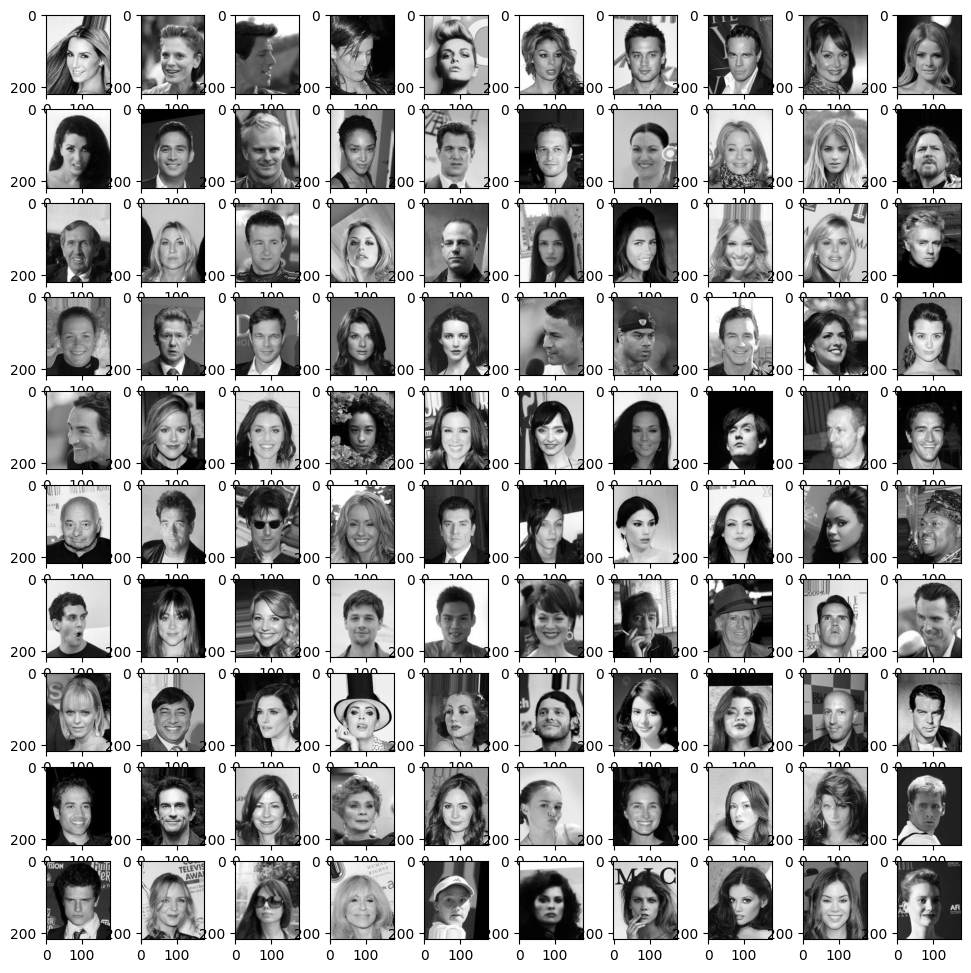

In [564]:
images = []
for i in range(1, 101):
  filename = f'{i:06}.jpg'
  img = cv2.imread(PATH + "/data/Q2 part1/" + filename)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  images.append(img)

plt.figure(figsize=(12,12))
for i in range(100):
  plt.subplot(10,10,i+1)
  plt.imshow(images[i], cmap="gray")

### Functions

In [565]:
def get_centered_image_vectors(images):
  image_vectors = []
  average_face = (np.mean(images, axis=0)).astype("float64").flatten()

  for img in images:
    img_vector = img.flatten().astype("float64")
    img_vector -= average_face
    image_vectors.append(img_vector)

  image_vectors = np.array(image_vectors, dtype="float64")
  return image_vectors

In [566]:
def get_sorted_eigenfaces(D):
  # solving the eigenvalue problem
  eig_values, eig_vectors = np.linalg.eig(np.cov(D))

  # sorting the eigen values and vectors from large to small in variance
  index = np.absolute(eig_values).argsort()[::-1]
  eig_values = eig_values[index]
  eig_vectors = eig_vectors[:, index]

  # calculating the eigenfaces from the low dimensional eigen vectors
  eig_faces = []
  for i in range(100):
    face = (D.T @ eig_vectors[:, i])
    face /= np.linalg.norm(face)
    eig_faces.append(face)

  return eig_faces

In [567]:
average_face = (np.mean(images, axis=0)).astype("float64").flatten()
def get_face_distance(x, y):
  query_vector = query_img_gray[y:y+218,x:x+178].reshape(218*178, )
  reconstructed_face = np.zeros((218*178, ), dtype="float64")
  weights = []
  for i in range(15):
    coef = np.dot(eig_faces[i], query_vector - average_face)
    weights.append(coef)
    reconstructed_face += coef * eig_faces[i]
  return np.linalg.norm(query_vector - reconstructed_face)

In [568]:
def detect_faces(query_img, threshold):
  w_size = images[0].shape
  query_size = query_img.shape
  distance_matrix = np.zeros(query_size)
  detected_list = []

  # each step is 20 pixels for less computation
  for i in range(0, query_size[0] - w_size[0], 20):
    for j in range(0, query_size[1] - w_size[1], 20):
      distance = get_face_distance(j, i)
      distance_matrix[i, j] = distance
      if distance < threshold:
        detected_list.append([j, i, distance])
        #print("detected")
  detected_list = np.array(detected_list)
  return detected_list

In [569]:
# reducing overlap by using non maximum suppression with threshold (minimum squared distance between detected points)
def non_max_suppression(detected_list, threshold):
  indices = np.argsort(detected_list[:, 2])
  detected_list_suppressed = []
  while len(indices) > 0:
    i = indices[0]
    current_detection = detected_list[i]
    detected_list_suppressed.append(list(current_detection))

    distances = []
    for other_detection in detected_list[indices[1:]]:
      distances.append((current_detection[0] - other_detection[0])**2 + (current_detection[1] - other_detection[1])**2)
    distances = np.array(distances)

    indices = indices[1:][distances > threshold]
  return detected_list_suppressed

In [570]:
def evaluate_accuracy(detected_list):
  num_total_detection = len(detected_list)
  true_positive = 0
  false_positive = 0
  person = [False] * 5
  for i in range(num_total_detection):
    x = detected_list[i][0]
    y = detected_list[i][1]
    if (120 <= x <= 200 and 200 <= y <= 300):
      person[0] = True

    elif (320 <= x <= 440 and 240 <= y <= 340):
      person[1] = True

    elif (580 <= x <= 680 and 140 <= y <= 260):
      person[2] = True

    elif (820 <= x <= 920 and 260 <= y <= 380):
      person[3] = True

    elif (1120 <= x <= 1200 and 240 <= y <= 320):
      person[4] = True

    else:
      false_positive += 1

  true_positive = person.count(True) / 5
  false_positive /= num_total_detection

  return true_positive, false_positive



---



### Eigenfaces

In [571]:
D = get_centered_image_vectors(images)
eig_faces = get_sorted_eigenfaces(D)

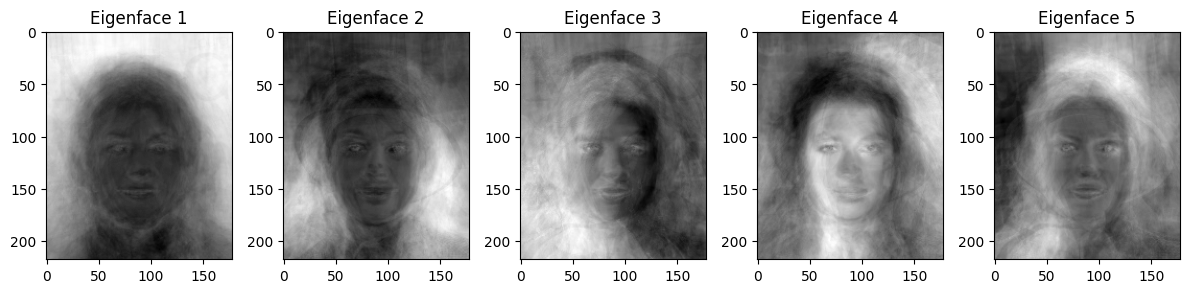

In [572]:
plt.figure(figsize=(12, 5))
for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(eig_faces[i].reshape(218, 178), cmap="gray")
  plt.title(f"Eigenface {i+1}")
plt.tight_layout()

### Fine-tuning

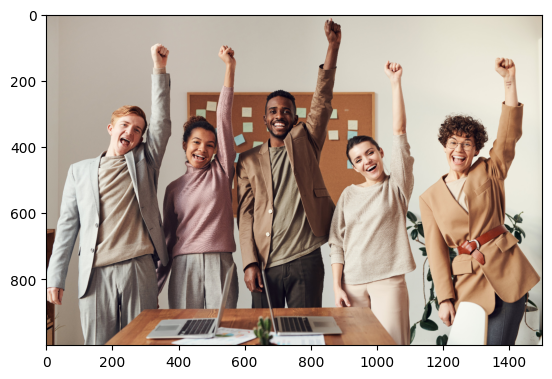

In [573]:
query_img = cv2.imread(PATH + "/data/Q2 part2/Person.png")
query_img = cv2.resize(query_img, (0,0), fx=0.25, fy=0.25)
query_img = cv2.cvtColor(query_img, cv2.COLOR_BGR2RGB)
query_img_gray = cv2.cvtColor(query_img, cv2.COLOR_RGB2GRAY)
query_img_gray = query_img_gray.astype("float64")
plt.imshow(query_img)

In [574]:
thresholds = [15500, 16000, 16500, 17000, 17500]
for thresh in thresholds:
  detected_list = detect_faces(query_img_gray, thresh)
  detected_list_suppressed = non_max_suppression(detected_list, 100**2)
  tp, fp = evaluate_accuracy(detected_list_suppressed)
  print(f"Threshold = {thresh}")
  print(f"True/Positive Rate: {tp:.3f}")
  print(f"False/Positive Rate: {fp:.3f}")
  print("\n")

Threshold = 15500
True/Positive Rate: 0.000
False/Positive Rate: 1.000


Threshold = 16000
True/Positive Rate: 0.200
False/Positive Rate: 0.750


Threshold = 16500
True/Positive Rate: 0.600
False/Positive Rate: 0.571


Threshold = 17000
True/Positive Rate: 0.600
False/Positive Rate: 0.727


Threshold = 17500
True/Positive Rate: 0.800
False/Positive Rate: 0.714




**Observations**

Here, the negative rates were not as important and could not be calculated because non maximum suppression has been applied to the detected points and the number of negative points could not be estimated. A threshold of 16500 has been chosen because the true/positive rate was relatively high while keeping the false/positive rate relatively low. However, a true positive rate and false positive rate of around 0.6 is not sufficient for application.

In [575]:
detected_list = detect_faces(query_img_gray, 16500)
detected_list_suppressed = non_max_suppression(detected_list, 100**2)

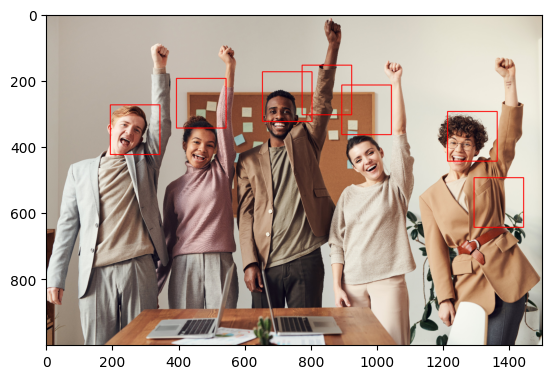

In [576]:
query_img_cp = query_img.copy()
for x, y, d in detected_list_suppressed:
  x = int(x)
  y = int(y)
  query_img_cp = cv2.rectangle(query_img_cp, (x + 178//2 - 75, y + 218//2 - 75), (x + 178//2 + 75, y + 218//2 + 75), (255,0,0), 2) # desizing rectangles from the original window size while maintaing the center
plt.imshow(query_img_cp)

In [577]:
tp, fnp = evaluate_accuracy(detected_list_suppressed)
print(f"True/Positive Rate: {tp:.3f}")
print(f"False/Positive Rate: {fp:.3f}")

True/Positive Rate: 0.600
False/Positive Rate: 0.714


### Pre-implemented Viola-Jones Face Detector

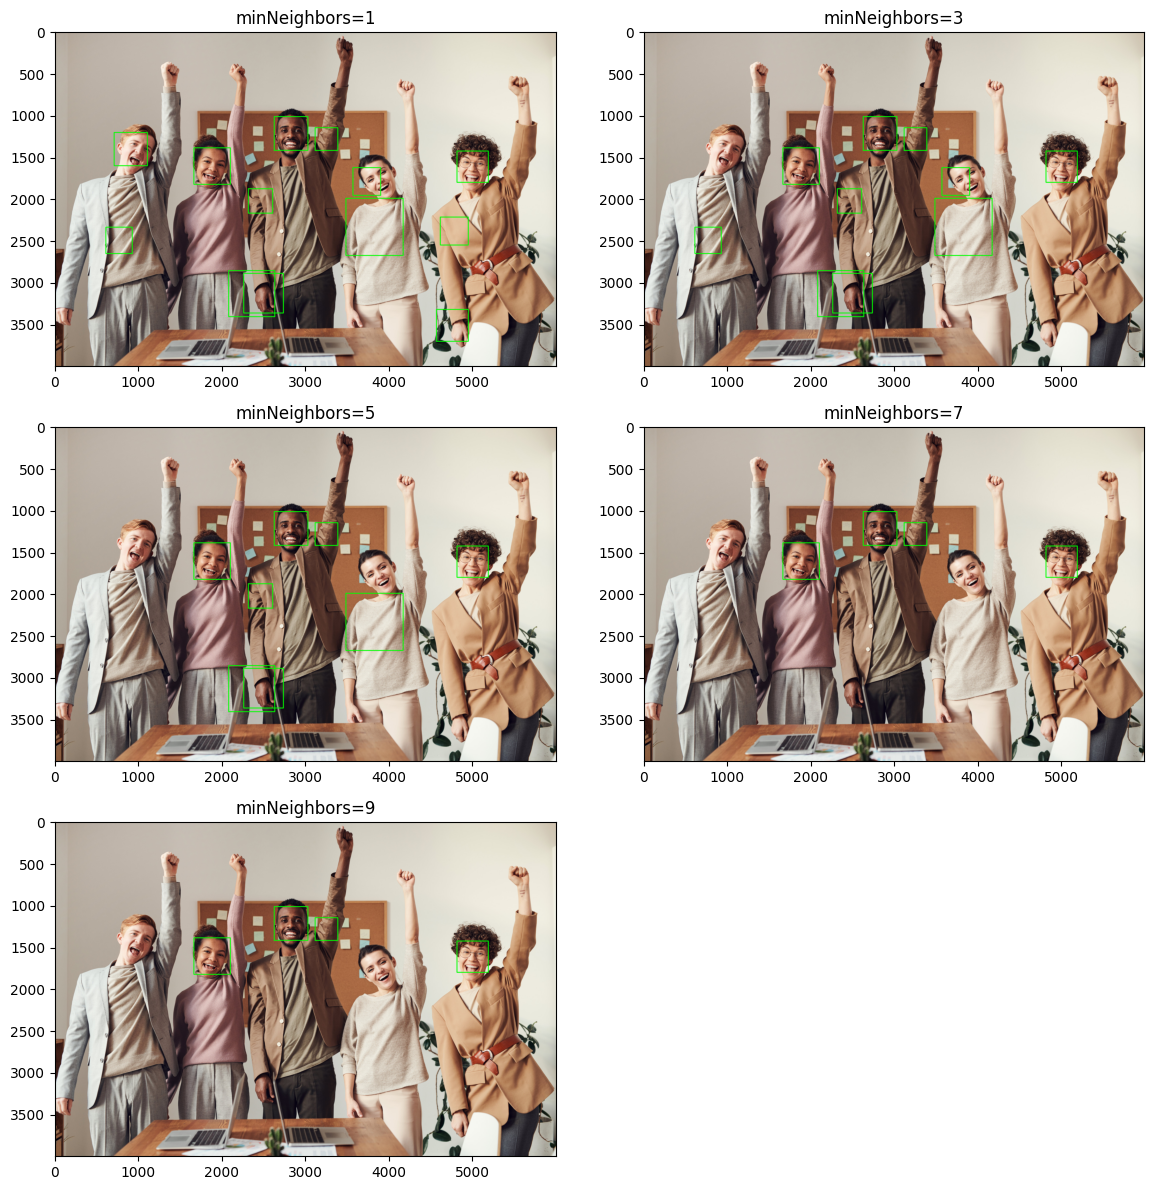

In [578]:
face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

min_neighbors = [1, 3, 5, 7, 9]
plt.figure(figsize=(12,12))
for i, minNeighbors in enumerate(min_neighbors):
  query_img = cv2.imread(PATH + "/data/Q2 part2/Person.png")
  query_img = cv2.cvtColor(query_img, cv2.COLOR_BGR2RGB)
  face = face_classifier.detectMultiScale(query_img, scaleFactor=1.05, minNeighbors=minNeighbors, minSize=(250, 250))
  for (x, y, w, h) in face:
    cv2.rectangle(query_img, (x, y), (x + w, y + h), (0, 255, 0), 10)
  plt.subplot(3, 2, i+1)
  plt.title(f"minNeighbors={minNeighbors}")
  plt.imshow(query_img)
plt.tight_layout()
#REFERENCE: https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html

### Comparison of PCA method and Viola-Jones Face Detector



**Evaluations**

The Viola-Jones Face Detector performed at a true/positive rate of 0.6 and a false/positive rate of 0.25 when the minimum neighbors parameter was set to 7 or 9. On the other hand, the PCA method performed at a true/positive rate of 0.6 and a false/positive rate of 0.6. Therefore, just by comparing the false/positive rates, the Viola-Jones Face Detector performed better. However, a true/positive rate of 0.6 is not high. In this case, two faces were not detected. From observation, the undetected faces were relatively more tilted than the detected faces. Thus, the Viola-Jones detector may also be variant to face orientation. However, the Viola-Jones detector is known for its speed and efficiency, which makes it suitable for real-time applications such as detection in video streams or webcams whereas PCA may involve more computation especially with high-dimensional data. The Viola-Jones detector is also known to be robust to variations in lighting and facial expressions, and to simple occlusions thanks to its cascaded classifiers using Haar-like features. It will also outperform the PCA method, when faces exist in different depth and their sizes vary. The PCA method is weaker in lighting variations and even simple occlusions.